<a href="https://colab.research.google.com/github/AlvinScrp/LLMs-from-scratch-CN/blob/main/mini-gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 一个简单的GPT2实现

In [1]:
# NBVAL_IGNORE_OUTPUT
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch version: 2.8.0+cu126
tiktoken version: 0.12.0


## 数据加载
* 文本：the-verdict.txt
* gpt2 tokenizer
* Dataloader
* token_embedding position_embedding


读取`raw_text`后续使用

In [2]:
import os##导入os库
import urllib.request ##导入request库

def readText(url,file_path):
  if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)
  with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()
  return text

#raw_text 后续使用
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
file_path="the-verdict.txt"
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_path="tinyshakespeare_input.txt"

raw_text = readText(url,file_path)
print(raw_text[:50])

First Citizen:
Before we proceed any further, hear


In [3]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []  # 输入ID列表
        self.target_ids = []  # 目标ID列表

        # 对整个文本进行分词
        token_ids = tokenizer.encode(txt, allowed_special={'<|endoftext|>'})

        # 使用滑动窗口将文本分割成重叠的最大长度序列
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]  # 输入片段
            target_chunk = token_ids[i + 1: i + max_length + 1]  # 目标片段（右移一个位置）
            self.input_ids.append(torch.tensor(input_chunk))  # 将输入片段转换为张量
            self.target_ids.append(torch.tensor(target_chunk))  # 将目标片段转换为张量

    def __len__(self):
        return len(self.input_ids)  # 返回数据集的大小

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]  # 获取特定索引的输入和目标

def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True,drop_last=True, num_workers=0):
    # 初始化分词器
    tokenizer = tiktoken.get_encoding("gpt2")
    # 创建数据集
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,drop_last=drop_last, num_workers=num_workers)

    return dataloader  # 返回数据加载器

测试代码

In [4]:
vocab_size = 50257  # 词汇表大小
output_dim = 256  # 输出维度
max_len = 1024  # 最大序列长度
context_length = max_len  # 上下文长度


token_embedding_layer = nn.Embedding(vocab_size, output_dim)  # 创建词嵌入层
pos_embedding_layer =  nn.Embedding(context_length, output_dim)  # 创建位置嵌入层

max_length = 4  # 每个输入片段的最大长度
dataloader = create_dataloader(raw_text, batch_size=8, max_length=max_length, stride=max_length)  # 创建数据加载器

tokenizer = tiktoken.get_encoding("gpt2")  # 初始化分词器
encoded_text = tokenizer.encode(raw_text)  # 对文本进行编码
print(raw_text[:50])
print(encoded_text[:8])
print(tokenizer.decode(encoded_text[:8]))
print('-'*20)
for batch in dataloader:
    x, y = batch

    token_embeddings = token_embedding_layer(x)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))

    input_embeddings = token_embeddings + pos_embeddings

    break
print(input_embeddings.shape)

First Citizen:
Before we proceed any further, hear
[5962, 22307, 25, 198, 8421, 356, 5120, 597]
First Citizen:
Before we proceed any
--------------------
torch.Size([8, 4, 256])


## 注意力机制

- 以下是之前实现的自注意力机制总结（为简化起见，未展示因果和dropout掩码）：

- 这种机制也称为单头注意力：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/24.webp" width="400px">

- 我们通过堆叠多个单头注意力模块来构建多头注意力模块：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/25.webp" width="400px">

- 多头注意力的核心思想是使用不同的学习到的线性投影，并行地多次运行注意力机制。这使得模型能够在不同位置同时关注来自不同表示子空间的信息。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/26.webp" width="400px">

### 带掩码的单头自注意力
仅示例，后续不会用到

In [5]:
class CausalSelfAttention(nn.Module):
    """
    该类实现了因果自注意力机制（Causal Self Attention），
    用于自回归模型（例如GPT模型中的注意力层）。
    """

    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        """
        初始化因果自注意力层。

        参数：
        - d_in: 输入维度
        - d_out: 输出维度
        - context_length: 上下文长度（即注意力机制能“看到”的最大令牌数）
        - dropout: Dropout率
        - qkv_bias: 是否为查询、键和值使用偏置（默认为False）
        """
        super().__init__()
        self.d_out = d_out
        # 定义查询、键、值的线性变换
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # Dropout层
        self.dropout = nn.Dropout(dropout)  # 新增的Dropout层

        # 注册一个buffer，用于存储因果掩码
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))  # 新增掩码，禁止未来的信息

    def forward(self, x):
        """
        前向传播函数计算因果自注意力输出。

        参数：
        - x: 输入的张量，形状为 (batch_size, num_tokens, d_in)

        返回：
        - context_vec: 自注意力机制的输出，形状为 (batch_size, num_tokens, d_out)
        """
        b, n_tokens, d_in = x.shape  # 获取输入张量的维度
        keys = self.W_key(x)  # 键（K）
        queries = self.W_query(x)  # 查询（Q）
        values = self.W_value(x)  # 值（V）

        # 计算注意力分数（查询和键的点积）
        attn_scores = queries @ keys.transpose(1, 2)  # 这里的转置（transpose）是为了匹配维度

        # 使用掩码阻止未来的tokens看到当前token
        attn_scores.masked_fill_(  # 这里的操作是原地修改
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf)  # 将掩码区域填充为负无穷

        # 计算注意力权重并进行softmax归一化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # 使用Dropout层

        # 计算上下文向量（加权和）
        context_vec = attn_weights @ values
        return context_vec

In [6]:
mask =torch.triu(torch.ones(4,4),diagonal=1)
# print(mask)
q=(torch.arange(1,25)*0.1).reshape(2,4,3).float() # Cast to float
k=(torch.arange(1,25)*0.1).reshape(2,4,3).float() # Cast to float
print(q)
score = q@k.transpose(1,2)
print(score)
print(torch.bmm(q,k.transpose(1,2)))
print(mask.bool())
score_masked =score.masked_fill_(mask.bool()[:4,:4],-torch.inf)
print(score_masked)
score_masked_softmax = torch.softmax(score_masked,dim=-1)
print(score_masked_softmax)

tensor([[[0.1000, 0.2000, 0.3000],
         [0.4000, 0.5000, 0.6000],
         [0.7000, 0.8000, 0.9000],
         [1.0000, 1.1000, 1.2000]],

        [[1.3000, 1.4000, 1.5000],
         [1.6000, 1.7000, 1.8000],
         [1.9000, 2.0000, 2.1000],
         [2.2000, 2.3000, 2.4000]]])
tensor([[[ 0.1400,  0.3200,  0.5000,  0.6800],
         [ 0.3200,  0.7700,  1.2200,  1.6700],
         [ 0.5000,  1.2200,  1.9400,  2.6600],
         [ 0.6800,  1.6700,  2.6600,  3.6500]],

        [[ 5.9000,  7.1600,  8.4200,  9.6800],
         [ 7.1600,  8.6900, 10.2200, 11.7500],
         [ 8.4200, 10.2200, 12.0200, 13.8200],
         [ 9.6800, 11.7500, 13.8200, 15.8900]]])
tensor([[[ 0.1400,  0.3200,  0.5000,  0.6800],
         [ 0.3200,  0.7700,  1.2200,  1.6700],
         [ 0.5000,  1.2200,  1.9400,  2.6600],
         [ 0.6800,  1.6700,  2.6600,  3.6500]],

        [[ 5.9000,  7.1600,  8.4200,  9.6800],
         [ 7.1600,  8.6900, 10.2200, 11.7500],
         [ 8.4200, 10.2200, 12.0200, 13.8200],
     

### 多头注意力
实际是合并多头权重，做矩阵运算。  而不是分别遍历单头计算，再合并

In [7]:
class MultiHeadAttention(nn.Module):
    """
    该类实现了多头自注意力机制（Multi-Head Attention），
    用于自回归模型（如Transformer和GPT中的注意力层）。
    """

    def __init__(self, d_in, d_out, context_length, dropout,num_heads, qkv_bias=False):
        """
        初始化多头自注意力层。

        参数：
        - d_in: 输入维度
        - d_out: 输出维度
        - context_length: 上下文长度（即注意力机制能“看到”的最大令牌数）
        - dropout: Dropout率
        - num_heads: 注意力头的数量
        - qkv_bias: 是否为查询、键和值使用偏置（默认为False）
        """
        super().__init__()

        # print(f'd_out:{d_out} ,num_heads :{num_heads}')
        # 检查输出维度是否能被头数整除
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # 将输出维度除以头数，得到每个头的维度

        # 定义查询、键、值的线性变换
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # 定义输出的线性变换层，用于合并多个头的输出
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        # 注册一个buffer，用于存储因果掩码
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))  # 新增掩码，禁止未来的信息

    def forward(self, x):
        """
        前向传播函数，计算多头自注意力输出。

        参数：
        - x: 输入张量，形状为 (batch_size, num_tokens, d_in)

        返回：
        - context_vec: 多头自注意力的输出，形状为 (batch_size, num_tokens, d_out)
        """
        b, num_tokens, d_in = x.shape  # 获取输入张量的维度

        # 计算键、查询和值的表示
        keys = self.W_key(x)  # 键（K）
        queries = self.W_query(x)  # 查询（Q）
        values = self.W_value(x)  # 值（V）

        # 将最后的维度按头数进行拆分：
        # 将 (b, num_tokens, d_out) 转换为 (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # 转置以适配矩阵相乘：
        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # 计算缩放点积注意力（self-attention）
        attn_scores = queries @ keys.transpose(2, 3)  # 点积计算每个头的注意力分数

        # 通过掩码将未来的信息遮掩（变成负无穷）
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # 将掩码转换为布尔类型
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # 使用掩码将未来的信息填充为负无穷

        # 计算注意力权重并进行softmax归一化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)  # 使用Dropout层

        # 计算上下文向量（加权和）
        context_vec = (attn_weights @ values).transpose(1, 2)  # 恢复维度 (b, num_tokens, num_heads, head_dim)

        # 合并头部的输出，并进行线性变换
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # 合并头的输出
        context_vec = self.out_proj(context_vec)  # 可选的投影层

        return context_vec

In [8]:
torch.manual_seed(123)

context_length = max_length
d_in = output_dim
d_out = d_in

mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

batch = input_embeddings
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([8, 4, 256])


## 模型结构简述

GPT-2使用的解码器与GPT-1有所不同。

GPT-2采用了所谓的预归一化方法，而GPT-1使用的是后归一化。预归一化的核心思想是在主体操作（即多头注意力机制和前馈网络模块）执行之前进行层归一化处理。


这种结构被称为 **Pre-LN (Pre-Layer Normalization)**。它与原始 Transformer 论文中将 LayerNorm 放在**之后**的 **Post-LN** 结构不同，优点在于：

  * **训练更稳定**: 在 Post-LN 结构中，梯度在反向传播时需要先穿过 LayerNorm，这可能导致梯度在深层网络中爆炸或消失。而在 Pre-LN 中，梯度可以直接通过残差连接的加法操作（梯度为1）无损地向前传播，使得整个网络的梯度流更加稳定，从而可以训练更深的模型。
  * **输出更规范**: Pre-LN 保证了输入到注意力层和 FFN 的数据始终是归一化后的，降低了对参数初始化的敏感度。

<img src="https://towardsdatascience.com/wp-content/uploads/2025/01/16GS2P6dpoWjMQkjDTN0cmA.png" width="500px">



架构参数

In [9]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
#初始化定义需要的各种超参数

## Add & Layer norm
- 残差连接：x + Sublayer(x)
- 层归一化：LayerNorm(x + Sublayer(x))

###  Residual Connections 残差连接
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/ResBlock.png/1200px-ResBlock.png" width="400px">

### LayerNorm 层归一化
层归一化是对每个序列中的每一个 Token 单独进行归一化，归一化的计算完全在 Token 内部的特征维度上进行。

LayerNorm 的计算逻辑非常简洁：

$$
y = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \cdot \gamma + \beta
$$

其中：

| 符号            | 含义                 |
| ------------- | --------------------- |
| x             | 输入特征向量             |
| mu (μ)        | 特征维度上的均值           |
| sigma\^2 (σ²) | 特征维度上的方差           |
| eps (ε)       | 防止除零的数值稳定项（如 1e-5） |
| gamma (γ)     | 可学习的缩放参数（scale）    |
| beta (β)      | 可学习的偏移参数（shift）    |

In [10]:
class LayerNorm(nn.Module):
    #layer归一化的函数,可以避免信息泄露也可以稳定
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 #避免0的产生导致崩溃
        self.scale = nn.Parameter(torch.ones(emb_dim)) #动态的缩放参数
        self.shift = nn.Parameter(torch.zeros(emb_dim)) #动态的偏移参数

    def forward(self, x):
        #设置 dim=-1 的意思是让计算沿着最后一个维度进行（在这里是特征维度），而不是按序列处理。
        mean = x.mean(dim=-1, keepdim=True)#算平均值
        var = x.var(dim=-1, keepdim=True, unbiased=False)#算方差
        #通过减去均值并除以方差的平方根（即标准差），可以让输入在列（特征）维度上的均值变为 0，方差变为 1
        norm_x = (x - mean) / torch.sqrt(var + self.eps)#归一化
        #γ 与 β 允许模型学习自适应的缩放与偏移，从而保留归一化前的表达能力。
        #在某些场景下，它们甚至可以「撤销」归一化带来的影响，让网络拥有更大的自由度。
        return self.scale * norm_x + self.shift

In [11]:
torch.set_printoptions(precision=8, sci_mode=False)
torch.manual_seed(123)
x=torch.randn(1,2,3)
print(x)
mean = x.mean(dim=-1, keepdim=True)
var = x.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

out_norm = (x - mean) / torch.sqrt(var)
#执行归一化操作
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

print("*"*10)
ln = LayerNorm(emb_dim=3)#归一化一个五维度
out_ln = ln(x)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)


tensor([[[-0.11146712,  0.12036294, -0.36963451],
         [-0.24041797, -1.19692433,  0.20926936]]])
Mean:
 tensor([[[-0.12024623],
         [-0.40935764]]])
Variance:
 tensor([[[0.06008218],
         [0.51575065]]])
Normalized layer outputs:
 tensor([[[ 0.03581607,  0.98161083, -1.01742685],
         [ 0.23524030, -1.09664845,  0.86140817]]])
Mean:
 tensor([[[0.],
         [0.]]])
Variance:
 tensor([[[1.00000000],
         [0.99999994]]])
**********
Mean:
 tensor([[[    0.00000000],
         [    0.00000004]]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[[0.99975038],
         [0.99997091]]], grad_fn=<VarBackward0>)


## GELU激活函数
- 在深度学习中，ReLU（线性整流单元）激活函数因其简单性和在各种神经网络架构中的高效性而被广泛使用。
- 在 LLM 中，除了传统的 ReLU，还使用了其他类型的激活函数。例如 GELU（高斯误差线性单元）
- GELU (高斯误差线性单元)是一种先进的平滑激活函数，它不像 ReLU 那样在零点进行“一刀切”式的硬性截断，而是根据输入值的统计概率来决定神经元在多大程度上被激活。
- 这种概率性的门控机制使得 GELU 的函数曲线处处平滑可导，并在负值区平滑过渡，这与 ReLU 在零点存在尖锐拐角且完全丢弃负值信息形成了鲜明对比。
- 总而言之，GELU 通过这种更“自然”的非线性变换，通常能为 Transformer 等现代模型带来优于 ReLU 的性能和更稳定的训练过程。
- **GELU**（[Hendrycks 和 Gimpel, 2016](https://arxiv.org/abs/1606.08415)）可以通过多种方式实现；其精确定义为 $\text{GELU}(x) = x \cdot \Phi(x)$，其中 $\Phi(x)$ 是标准高斯分布的累积分布函数。
- 在实际应用中，通常会使用一种计算成本更低的近似形式：  
  $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$  
  （原始 GPT-2 模型也是使用该近似公式进行训练的）。

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            #这一步把它变得平滑了很多
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

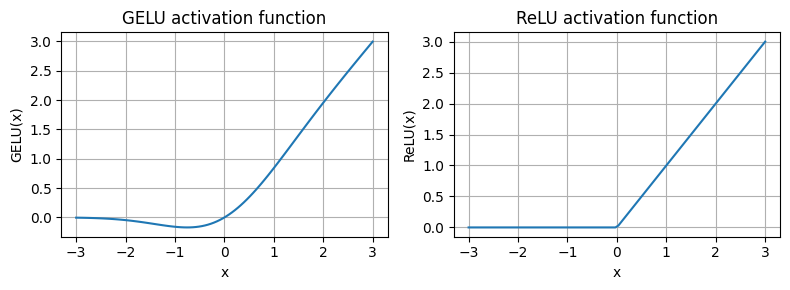

In [13]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()#先把函数给个小名

# Some sample data
x = torch.linspace(-3, 3, 100) #初定义一个张量
y_gelu, y_relu = gelu(x), relu(x) #两种激活函数

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()
#一个经典的作图

## PositionWiseFFN 基于位置的前馈神经网络
在原始 Transformer 论文、GPT-1、GPT-2 以及后续绝大多数基于 Transformer 的模型（包括 GPT-3, LLaMA 等）中，前馈网络（Feed-Forward Network, FFN）部分都采用了将输入维度扩大4倍，然后再还原回原始维度的结构。
> emb_dim -> 4 * emb_dim -> emb_dim

这已经成为了 Transformer 架构中的一个标准设计模式。

通过将输入 emb_dim 投影到一个更高维的空间（4 * emb_dim），模型在这个“更宽”的空间里有更多的能力去学习和拟合复杂的函数和模式。激活函数（如 GELU）在这个高维空间中进行操作，可以组合出比在原始低维空间中更丰富的特征。最后，第二个线性层再将这些丰富的信息“压缩”并投影回原始的 emb_dim，以便于后续的残差连接。

这个过程可以被直观地理解为一个**“记忆”或“特征提取器”**：

- 1.第一个线性层将注意力层的输出投影到一个巨大的“特征库”中。

- 2.GELU 激活函数根据输入，“点亮”或“激活”了库中相关的特征。

- 3.第二个线性层根据被激活的特征，重新组合成一个有意义的输出。

In [14]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear_1 = nn.Linear(emb_dim, 4 * emb_dim)
        self.active = GELU()
        # 你要找的是这个层
        self.linear_2 = nn.Linear(4 * emb_dim, emb_dim)
    #运行一次就线性两次激活一次
    def forward(self, x):
        return self.linear_2(self.active(self.linear_1(x)))

## GPT2DecoderBlock

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="600px">


In [15]:
import math
class GPT2DecodeBlock(nn.Module):
  def __init__(self,emb_dim,context_length,num_heads,num_layers,dropout_rate,qkv_bias=False):
    super().__init__()
    self.attention = MultiHeadAttention(emb_dim,emb_dim,context_length,dropout_rate,num_heads,qkv_bias)
    self.ffn = FeedForward(emb_dim)
    self.layerNorm1 = LayerNorm(emb_dim)
    self.layerNorm2 = LayerNorm(emb_dim)
    self.dropout = nn.Dropout(dropout_rate)

    # 2. 对直接连接到残差路径的层进行权重缩放
    #    这里我们假设 attention 模块的输出层叫 out_proj, ffn 的第二个线性层也叫 linear_2
    #    这是 GPT-2 实践中常见的做法
    if hasattr(self.attention, 'out_proj') and hasattr(self.ffn, 'linear_2'):
        # 缩放因子分母中的 2*n_layers 代表整个模型中残差连接的总数
        scale_factor = math.sqrt(2 * num_layers)

        # 对多头注意力的输出投射层权重进行缩放
        # 使用正态分布进行初始化，但标准差要除以缩放因子
        torch.nn.init.normal_(self.attention.out_proj.weight, mean=0.0, std=0.02 / scale_factor)

        # 对前馈网络的第二个线性层权重进行缩放
        torch.nn.init.normal_(self.ffn.linear_2.weight, mean=0.0, std=0.02 / scale_factor)
    else:
        print("Warning: c_proj layer not found in attention or ffn. Residual scaling not applied.")

  def forward(self,x):
    # 对注意力模块的快捷连接
    sourceX = x
    x = self.layerNorm1(x)  # 应用第一归一化层
    x = self.attention(x)  # 通过多头注意力模块，形状为 [batch_size, num_tokens, emb_size]
    x = self.dropout(x)  # 应用 Dropout
    x = sourceX + x   # 将原始输入加回，实现残差连接

    # 对前馈网络模块的残差连接
    sourceX = x
    x = self.layerNorm2(x)  # 应用第二归一化层
    x = self.ffn(x)  # 通过前馈神经网络模块
    x = self.dropout(x)  # 应用 Dropout
    x = sourceX + x   # 将原始输入加回，实现残差连接

    return x



##GPT2Model
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="600px">


In [16]:
class GPT2Model(nn.Module):
  def __init__(self,cfg):
    super().__init__()

    vocab_size = cfg['vocab_size']
    emb_dim = cfg['emb_dim']
    context_length = cfg['context_length']
    num_heads = cfg['n_heads']
    n_layers = cfg['n_layers']
    dropout_rate = cfg['drop_rate']
    qkv_bias = GPT_CONFIG_124M['qkv_bias']

    self.tokenEmb = nn.Embedding(vocab_size,emb_dim)
    self.postionEmb = nn.Embedding(context_length,emb_dim)
    self.embDrop = nn.Dropout(dropout_rate)
    self.decodeBlock = nn.Sequential(
        *[GPT2DecodeBlock(emb_dim,context_length,num_heads,n_layers,dropout_rate,qkv_bias) for _ in range(n_layers)]
    )
    self.finalLayerNorm = LayerNorm(emb_dim)
    self.outputLinear = nn.Linear(emb_dim,vocab_size)

  def forward(self,in_idx):
    # print(f'forward:{in_idx.shape}')
    batch_size,seq_len, = in_idx.shape
    t = self.tokenEmb(in_idx)
    # print(f't:{t}')

    p = self.postionEmb(torch.arange(seq_len,device=in_idx.device))
    # print(f'p:{p}')
    x = t + p
    x = self.embDrop(x)
    x = self.decodeBlock(x)
    x = self.finalLayerNorm(x)
    logits = self.outputLinear(x)
    return logits



In [17]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
#召唤gpt大神
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
#编码输入文本
batch = torch.stack(batch, dim=0)
#按照横向来叠加两个向量
print(batch)

torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch.shape)
print("\nOutput shape:", out.shape)
print(out)
#经典操作

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch:
 torch.Size([2, 4])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.67021072, -0.11701202,  0.66688609,  ..., -0.26471528,
          -0.12174553,  0.41084272],
         [ 1.06572163,  0.10397913, -0.78689599,  ..., -0.00584517,
          -0.32707059, -0.43906075],
         [ 1.22527230, -0.06391940,  0.00197700,  ...,  0.23192315,
           0.23940712, -0.43113047],
         [ 0.09830917, -1.87013948, -0.17989337,  ...,  0.56980181,
           1.67695785,  0.08691657]],

        [[-1.04739201, -0.29219455,  0.68777657,  ...,  0.10014866,
          -0.27383161,  0.24262302],
         [-0.27236503,  0.13881294, -0.58485043,  ..., -0.24671817,
          -0.06416282, -0.26006654],
         [-0.03176545,  0.28174189, -0.27445188,  ..., -0.12406659,
          -0.14826363, -0.74223864],
         [-0.48546624, -0.78222084, -0.06669599,  ..., -0.21058434,
           1.29266810, -0.60820180]]], grad_fn=<View

## 其他


### 模型容量
原始 GPT-2 论文中，研究人员采用了权重共享（weight tying）技术，即将标记嵌入层（tok_emb）作为输出层复用，具体表现为设置 self.outputLinear.weight = self.tokenEmb.weight。

In [18]:
total_params = sum(p.numel() for p in model.parameters())
#模型的总参数数量
print(f"Total number of parameters: {total_params:,}")

#Parameter- sharing
total_params_gpt2 =  total_params - sum(p.numel() for p in model.outputLinear.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")


# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

#计算总的容量
print(f"Total size of the model: {total_size_mb:.2f} MB")


Total number of parameters: 163,059,793
Number of trainable parameters considering weight tying: 124,412,160
Total size of the model: 622.02 MB


###  初步测试文本生成
-  `generate_text_simple` 实现了一个迭代过程，其中它一次生成一个token。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

In [19]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx 是当前上下文中的（batch, n_tokens）索引数组
    for _ in range(max_new_tokens):
        # 每次生成一个单词后，重新将其加入序列中
        # idx_cond的序列长度不能超过context_size，否则截取后context_size个
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # 只关注最后一个时间步的输出
        # (batch, n_tokens, vocab_size) 变为 (batch, vocab_size)
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # 将采样的索引添加到序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

# I HAD always thought Jack Gisburn rather a cheap genius
start_context = "I HAD always thought"
#模拟
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
#进行语义理解
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)
#最终输出格式

model.eval() # disable dropout
#在检验的时候不需要正则化了
out = generate_text_simple(
    model=model,
    #左边的参数名字,右边是函数传入的实际模型
    idx=encoded_tensor, #上下文的索引
    max_new_tokens=6, #最多运行六次,然后取结果概率最高的
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))
#输出长度还有每个单词的id

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)


import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
#举个例子
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    #初始上下文的Token ID张量，是上一步 text_to_token_ids 的输出
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
#输出最长单词度为10的句子
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

encoded: [40, 367, 2885, 1464, 1807]
encoded_tensor.shape: torch.Size([1, 5])
Output: tensor([[   40,   367,  2885,  1464,  1807, 42581,  3544, 38205,  4761,   319,
         32628]])
Output length: 11
I HAD always thoughtudence uses69672 on mantra
Output text:
 Every effort moves you Constantfunctional combines laurebara Rolling Admiral soarideshow shading


# 自监督预训练

## 交叉熵损失(cross-entropy-loss)和困惑度(perplexity)
实现交叉熵损失（Cross-Entropy Loss）可以从两个层面来理解：一是自己动手从零实现以理解其原理，二是直接使用 PyTorch、TensorFlow 等深度学习框架中已经优化好的函数。

### 0. softmax
Softmax函数是一个将一组实数转换为概率分布的数学公式。

在机器学习中，它主要用于将模型输出的原始分数（称为**logits**）转换为多类别分类问题中的概率。转换后，所有类别的概率总和为1，这使得模型的输出易于理解。

对于向量 $z$ 中的分数 $z_i$，其公式为：

$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

其中：
* $z_i$ 是第 $i$ 个类别的输入分数。
* $e^{z_i}$ 是应用于该分数的标准指数函数，它使所有输出都为正数。
* $\sum_{j=1}^{K} e^{z_j}$ 是所有分数指数的总和，作为归一化因子。

### 1. 核心概念与原理

交叉熵损失是分类问题中最常用的损失函数。它的核心思想是**衡量模型预测的概率分布与真实的标签概率分布之间的差异**。

  * **真实分布 (True Distribution)**：在分类问题中，一个样本只属于一个类别。我们通常用独热编码（One-Hot Encoding）来表示，例如对于一个三分类问题，标签为 "类别1" 的真实分布就是 `[1, 0, 0]`。
  * **预测分布 (Predicted Distribution)**：这是模型经过 Softmax 函数后输出的，表示模型认为样本属于每个类别的概率，例如 `[0.7, 0.2, 0.1]`。

交叉熵损失值越小，说明模型的预测分布越接近真实分布，模型性能越好。


### 2. 数学公式

对于单个样本，交叉熵损失的计算公式如下：

$$L = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

其中：

  * $C$ 是类别的总数。
  * $y_i$ 是真实分布的第 $i$ 个元素（对于 One-Hot 编码，如果真实类别是 $i$，则 $y_i=1$，否则 $y_i=0$）。
  * $\hat{y}_i$ 是模型预测样本属于类别 $i$ 的概率。

#### **公式简化**

因为 $y$ 是 One-Hot 向量，只有一个位置是 1（假设为类别 $k$），其他位置都是 0。所以上面那个求和公式可以大大简化：

$$L = - (0 \cdot \log(\hat{y}_1) + \dots + 1 \cdot \log(\hat{y}_k) + \dots + 0 \cdot \log(\hat{y}_C)) = -\log(\hat{y}_k)$$

**简化后的直观理解**：单个样本的损失，就是**模型预测的正确类别的概率的负对数**。

  * 如果模型对正确类别 $k$ 的预测概率 $\hat{y}_k$ 很高（如 0.99），那么 $-\log(0.99)$ 是一个很小的数，损失很小。
  * 如果模型对正确类别 $k$ 的预测概率 $\hat{y}_k$ 很低（如 0.01），那么 $-\log(0.01)$ 是一个很大的数，损失很大。这会驱动模型更新参数，提高正确类别的预测概率。

### 3. 从零开始实现 (使用 NumPy)

为了真正理解其工作原理，我们可以用 NumPy 来手动实现。这通常包括两步：Softmax 函数和交叉熵计算。

In [20]:
import numpy as np
def softmax(logits):
    """
    计算 softmax 函数
    Args:
        logits: 模型的原始输出，形状为 (batch_size, num_classes)
    Returns:
        probs: 概率分布，形状和 logits 相同
    """
    # 为了数值稳定性，减去最大值防止 exp 溢出
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def cross_entropy_loss_manual(logits, y_true):
    """
    手动实现交叉熵损失
    Args:
        logits: 模型的原始输出 (batch_size, num_classes)
        y_true: 真实的标签，整数索引 (batch_size,)
    Returns:
        loss: 批次的平均损失
    """
    batch_size = logits.shape[0]

    # 1. 计算概率
    probs = softmax(logits)

    # 2. 提取正确类别的预测概率
    # 使用高级索引，从 probs 的每一行中，根据 y_true 中指定的列索引提取概率值
    correct_class_probs = probs[np.arange(batch_size), y_true]

    # 3. 计算负对数损失
    # 添加一个很小的数 epsilon 防止 log(0) 导致 -inf
    epsilon = 1e-9
    log_probs = -np.log(correct_class_probs + epsilon)

    # 4. 计算批次的平均损失
    loss = np.mean(log_probs)

    return loss


### 4. 使用 PyTorch 内置函数 (推荐)

在实际应用中，我们**强烈推荐**使用框架内置的函数，因为它们经过了高度优化，并且能自动处理数值稳定性问题。

PyTorch 中的 `torch.nn.CrossEntropyLoss` 是一个非常方便的模块, 内部**自动**包含了 `Softmax` 操作。因此，**你只需要将模型的原始输出（logits）直接传入即可**，不需要自己手动调用 Softmax。

CrossEntropyLoss 内部实际是通过`Log-Sum-Exp Trick`(nn.LogSoftmax)和 负对数似然损失 (nn.NLLLoss) 实现。

你会发现，手动实现的结果和 PyTorch 计算的结果几乎完全一样（可能因浮点数精度有微小差异）。

In [21]:
import torch
import torch.nn as nn

# --- 示例 ---
# 假设批次大小为 2，共 3 个类别
# 模型的原始输出（logits），需要是 FloatTensor
sample_logits_torch = torch.tensor([
    [2.0, 8.0, 0.1],
    [0.5, 1.5, 1.5]
], dtype=torch.float32)

# 真实标签（类别索引），需要是 LongTensor
sample_y_true_torch = torch.tensor([0, 2], dtype=torch.long)

# PyTorch 默认计算批次的平均损失 (reduction='mean')
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(sample_logits_torch, sample_y_true_torch)
print(f"PyTorch内置的交叉熵损失: {loss.item():.4f}")


lossManual = cross_entropy_loss_manual(sample_logits_torch.numpy(), sample_y_true_torch.numpy())
print(f"手动实现的交叉熵损失: {lossManual:.4f}")

PyTorch内置的交叉熵损失: 3.4324
手动实现的交叉熵损失: 3.4324


### 困惑度
- 与交叉熵损失相关的一个概念是大语言模型的困惑度 (perplexity)。
- 困惑度就是交叉熵损失的指数值。
- 困惑度通常被认为更易解释，因为它可以理解为模型在每一步对词汇表大小的不确定性，值越大表示可能的token越多。
- 换句话说，困惑度提供了一个衡量模型预测的概率分布与数据集中单词实际分布匹配程度的指标。
- 类似于损失值，较低的困惑度表示模型预测与实际分布的差距较小。

In [22]:
perplexity = torch.exp(loss)
#指数化loss作为P值
print(perplexity)

tensor(30.95145416)


## 计算训练集和验证集的损失

In [23]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

- 我们在上述代码中使用了 0.1 的 dropout 率，但如今训练大语言模型时通常不使用 dropout。
- 现代的大语言模型不在 `nn.Linear` 层的查询、键和值矩阵中使用偏置向量（与早期的 GPT 模型不同），而是通过设置 `"qkv_bias": False` 实现。
- 我们将上下文长度（`context_length`）减少到仅 256 个 token，以减少训练模型时的计算资源需求，而原始的 1.24 亿参数的 GPT-2 模型使用了 1024 个token。
  - 这是为了让更多读者可以在他们的笔记本电脑上运行并跟随代码示例。
  - 然而，您可以自由将 `context_length` 增加到 1024 个 token（这不需要更改任何代码）。
  - 我们稍后也将从预训练权重中加载一个具有 1024 `context_length` 的模型。

In [24]:
print(raw_text[:99])
print(raw_text[-99:])
#统计一下文本的长度,编码文本内容并输出文本个数
print("Characters:", len(raw_text))
print("Tokens:", len(tokenizer.encode(raw_text)))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
Yo
ONIO:
Noble Sebastian,
Thou let'st thy fortune sleep--die, rather; wink'st
Whiles thou art waking.

Characters: 1115394
Tokens: 338025


In [25]:
# Train/validation ratio
train_ratio = 0.80
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

#依旧保持可复现
torch.manual_seed(123)

#初始化输入训练模型,给出批处理的大小、给出最大文本容量防止溢出
#给出不畅,丢弃最后一批不足的文本,打开随机防止拟合过度
train_loader = create_dataloader(
    train_data,
    batch_size=32,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

#验证数据集仅仅修改了是否丢弃跟随抽取
val_loader = create_dataloader(
    val_data,
    batch_size=32,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


In [26]:
total_tokens = len(tokenizer.encode(raw_text))
print(total_tokens * (train_ratio),total_tokens * (1-train_ratio),GPT_CONFIG_124M["context_length"])
# for x, y in train_loader:
#     print(x.shape, y.shape)

# print("\nValidation loader:")
# for x, y in val_loader:
#     print(x.shape, y.shape)

270420.0 67604.99999999999 256


In [27]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    loss = nn.CrossEntropyLoss()
    import time
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = logits.view(-1, logits.size(-1))
            target_batch = target_batch.view(-1)

            l = loss(logits, target_batch)
            l.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1


        train_l = evaluate_model(model,train_loader,loss)
        val_l = evaluate_model(model, val_loader,loss)
        train_losses.append(train_l)
        val_losses.append(val_l)
        track_tokens_seen.append(tokens_seen)
        end_time = time.time()
        execution_time_minutes = (end_time - start_time) / 60
        print(f"耗时 {execution_time_minutes:.2f} 分钟。")

        print(f"Ep {epoch+1} : "
                      f"Train loss {train_l:.3f}, Val loss {val_l:.3f}"
                      f"耗时 {execution_time_minutes:.2f} 分钟。")

        # Print a sample text after each epoch
        generate_and_print_sample( model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, data_loader,  loss):
    """
    计算给定数据加载器上模型的每个样本的平均损失
    """
    model.eval()  # 将模型设置为评估模式，这会关闭Dropout
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # 在评估时不需要计算梯度，可以节省计算资源和内存
        for input_batch, target_batch in data_loader:
            size = input_batch.size(0)
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = logits.view(-1, logits.size(-1))
            target_batch = target_batch.view(-1)

            l = loss(logits, target_batch)
            total_loss += l.item() * size
            total_samples += size

    model.train()  # 如果后续还需要训练，记得将模型切换回训练模式

    epoch_loss = total_loss / total_samples
    return epoch_loss



def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.postionEmb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [28]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs,
    eval_freq=5,
    # start_context="I have mentioned that Mrs",
    start_context="Still cupboarding the viand",
    tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"训练完成耗时 {execution_time_minutes:.2f} 分钟。")


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.54 GiB. GPU 0 has a total capacity of 14.74 GiB of which 638.12 MiB is free. Process 7296 has 14.12 GiB memory in use. Of the allocated memory 13.92 GiB is allocated by PyTorch, and 69.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Still cupboarding the viand, never bearing
Like labour with the rest, where the other instruments
Did see and hear, devise, instruct, walk, feel,
And, mutually participate, did minister
Unto the appetite and affection common
Of the whole body. The belly answer'd--

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
#一个经典的plot画图函数

 `the-verdict.txt` 文件确实非常小，只有几千个单词，主要用于教学演示，让代码能快速跑通。要训练一个稍微有点样子的模型，你需要大得多的文本。

这里为你推荐几个不同量级的文本数据链接，从易到难，你可以根据自己的需求选择。

### 1\. 直接替换的单个 .txt 文件 (中等大小)

这是一个最直接的“升级”选择，和 `the-verdict.txt` 一样，是一个单独的 `.txt` 文件，但内容要多得多。

**推荐：莎士比亚全集 (The Complete Works of William Shakespeare)**

这个文件大约有 1.1MB，包含了莎士比亚所有的戏剧和诗歌。它是 NLP 入门领域非常经典的语料库。

  * **链接:**
    ```
    https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
    ```
  * **优点:**
      * 比 `the-verdict.txt` 大上百倍。
      * 单一 `.txt` 文件，无需处理，可以直接下载使用。
      * 文本风格统一，语言经典。
  * **缺点:**
      * 内容是古英语，和现代英语有差异。

### 2\. 需要简单代码处理的数据集 (大)

对于更严肃的训练，通常不会用单个 `.txt` 文件，而是使用专门的数据集。Hugging Face 的 `datasets` 库是获取它们的标准方式。你只需要几行代码就可以下载并整合成一个大文本文件。

**推荐：TinyStories 数据集**

这是一个专门为训练小型语言模型设计的高质量数据集，由 GPT-3.5 和 GPT-4 生成的简短故事组成，内容简单、语法正确、逻辑连贯。

  * **优点:**
      * 数据量大且质量非常高，非常适合从零开始训练。
      * 内容是现代、简单的英语，模型更容易学习。
  * **如何使用:**
    你需要先安装 `datasets` 库:
    ```bash
    pip install datasets
    ```
然后用下面的 Python 脚本来下载并保存为文本文件：

In [ ]:
from datasets import load_dataset
import os

# 下载数据集（会自动缓存）
print("Downloading TinyStories dataset...")
dataset = load_dataset("roneneldan/TinyStories", split='train')

# 定义要保存的文件名
output_filename = "tinystories.txt"

# 设定要处理的数据条数 (可以先用少量数据测试)
# 例如，只处理前 10000 个故事
num_stories_to_process = 10000

print(f"Processing and writing to {output_filename}...")
with open(output_filename, "w", encoding="utf-8") as f:
    for i, story in enumerate(dataset):
        if i >= num_stories_to_process:
            break
        f.write(story['text'])
        f.write("\n\n") # 每个故事之间用两个换行符隔开
        if (i + 1) % 1000 == 0:
            print(f"Processed {i+1}/{num_stories_to_process} stories.")

file_size = os.path.getsize(output_filename) / (1024 * 1024)
print(f"Done. File '{output_filename}' created successfully.")
print(f"File size: {file_size:.2f} MB")

如果你想处理整个数据集，请移除 num_stories_to_process 的限制
注意：完整的数据集非常大，生成的 .txt 文件会达到 GB 级别，请确保磁盘空间充足


### 3\. 更大规模的语料库 (超大)

如果你想进一步挑战，可以尝试使用维基百科的数据。

**推荐：维基百科英文数据 (Wikipedia)**

这是训练大型模型常用的高质量语料库之一。

  * **如何使用:**
    同样可以使用 `datasets` 库来获取处理好的维基百科数据。
    ```python
    from datasets import load_dataset

    # 下载一个处理好的维基百科数据快照
    # 这会下载很大的数据，请确保网络和磁盘空间足够
    dataset = load_dataset("wikipedia", "20220301.en", split='train')

    # 后续处理方式与 TinyStories 类似，将'text'字段写入文件
    # 但要注意，这个数据集非常庞大，建议先取一小部分进行操作
    ```

### 总结与建议

  * **新手入门/快速实验:** 直接使用 **莎士比亚全集** 的链接。它是最简单的升级方案。
  * **认真学习/训练小模型:** 强烈推荐 **TinyStories 数据集**。它的数据质量和规模都非常适合《LLMs from scratch》这本书的后续学习。
  * **进阶挑战:** 当你熟悉了整个流程后，可以尝试使用 **维基百科** 的一部分数据来训练更大的模型。